# Simple 2-D neural network classifier

In [21]:
# Import modules
import os
import sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

print('Python working path: {}'.format(sys.executable))

Python working path: /Users/apartin/anaconda/envs/py35_tf14/bin/python


In [2]:
# Import DL modules
import tensorflow as tf
import keras
print('TensorFlow version: {}'.format(tf.__version__))
print('Keras version: {}'.format(keras.__version__))

Using TensorFlow backend.


TensorFlow version: 1.4.0
Keras version: 2.1.2


In [3]:
# Import Keras methods
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

## Action plan
General steps for training and evaluationg a neural network in Keras:
1. Prepare the data (get the data and pre-process)
2. Create the model (neural network architecture)
3. Compile the model (define loss function and optimizer)
4. Train the model
5. Evaluate the model (on val/test data)

In [4]:
def create_toy_dataset(n_samples=100, n_classes=3, to_plot=False):
    """
    Creates a 2-D dataset.
    Adapted from https://cs231n.github.io/neural-networks-case-study/
    n_samples: number of points per class
    n_classes: dimensionality
    """
    N = n_samples
    K = n_classes
    D = 2  # dimensionality of the data (features)

    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K, dtype='uint8')  # class labels

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0.0, 1, N)  # radius
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j

    if to_plot:
        plt.figure(figsize=(6, 6))
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
        plt.axis('equal')
        plt.show()

    return X, y

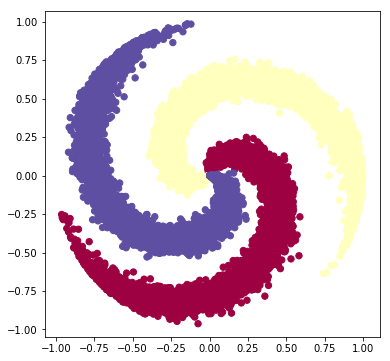

In [5]:
X, y = create_toy_dataset(n_samples=5000, n_classes=3, to_plot=True)

In [10]:
# Dataset shape
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (15000, 2)
y shape: (15000,)


In [11]:
y

array([0, 0, 0, ..., 2, 2, 2], dtype=uint8)

In [12]:
# One-hot encode the target variable
y_onehot = to_categorical(y)
y_onehot

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

<img src="figures/2d_classifier.png" width=50%>

- Keras core layers: https://keras.io/layers/core/
- Keras loss functions: https://keras.io/losses/
- Keras optimizers: https://keras.io/optimizers/

In [13]:
def create_2d_classifier(labels, activation='relu'):
    """Creates a fully-connected neural network classifier."""
    # Input dimension
    input_dim = 2
    
    # Compute the number of classes (output dimension)
    if np.squeeze(labels).ndim == 1:
        out_dim = len(np.unique(labels))
    elif np.squeeze(labels).ndim == 2:
        out_dim = labels.shape[1]
    else:
        raise ValueError('The `labels` variable should be either 1-D or 2-D shape.')

    model = Sequential()
    model.add(Dense(units=32, activation=activation, input_shape=(input_dim,)))  # num of parameters: 2*32 + 32 = 96
    model.add(Dense(units=32, activation=activation))  # num of parameters: 32*32 + 32 = 1056
    model.add(Dense(units=out_dim, activation='softmax'))  # num of parameters: 16*2 + 2 = 34
    return model

In [14]:
model = create_2d_classifier(labels=y, activation='relu')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy',  # binary_crossentropy
              optimizer='rmsprop',
              metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(x=X,            # training data/features
                    y=y_onehot,     # training labels
                    batch_size=32,  # backpropagate gradients computed on batch_size samples
                    epochs=5)      # number of times to use the whole training set to train the model

Epoch 1/5
15000/15000 [==============================] - 1s 64us/step - loss: 0.6674 - acc: 0.6396
Epoch 2/5
15000/15000 [==============================] - 1s 37us/step - loss: 0.2649 - acc: 0.9297
Epoch 3/5
15000/15000 [==============================] - 1s 38us/step - loss: 0.1090 - acc: 0.9823
Epoch 4/5
15000/15000 [==============================] - 1s 35us/step - loss: 0.0633 - acc: 0.9903
Epoch 5/5
15000/15000 [==============================] - 1s 36us/step - loss: 0.0442 - acc: 0.9931


In [17]:
def plot_decision_boundaries(X, y, classifier, resolution=0.01):
    """Plot decision boundaries for a classifier."""
    marker = ('o', 's', 'v', 'x')
    color = ('red', 'blue', 'gray', 'lightgreen')
    cmap = ListedColormap(color[:len(np.unique(y))])

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    xx = np.array([xx1.ravel(), xx2.ravel()]).T  # or reshape(-1,2)
    z = classifier.predict(xx)
    z = np.argmax(z, axis=1)
    z = z.reshape(xx1.shape)
    plt.figure(figsize=(6, 6))
    plt.contourf(xx1, xx2, z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot the dataset samples
    for idx, label in enumerate(np.unique(y)):
        plt.scatter(x=X[y==label, 0],
                    y=X[y==label, 1],
                    alpha=0.5,
                    c=color[idx],
                    marker=marker[idx],
                    label=label)
    plt.legend(loc='upper left')

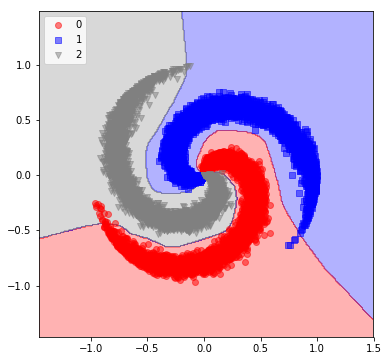

In [18]:
plot_decision_boundaries(X, y, classifier=model, resolution=0.01)

### Why do we need activation functions?

- Activation functions (wiki page): https://en.wikipedia.org/wiki/Activation_function
- Activation functions allows us to learn non-linear representations
- ReLU (Rectified Linear Unit)

<img src="figures/relu.png" width=30%>

In [ ]:
# The same classifier as before but without an activation function
model = create_2d_classifier(labels=y_onehot,
                             activation=None)

Epoch 1/10
15000/15000 [==============================] - 1s 61us/step - loss: 0.7603 - acc: 0.5275
Epoch 2/10
15000/15000 [==============================] - 1s 41us/step - loss: 0.7449 - acc: 0.5293
Epoch 3/10
15000/15000 [==============================] - 1s 41us/step - loss: 0.7447 - acc: 0.5285
Epoch 4/10
15000/15000 [==============================] - 1s 40us/step - loss: 0.7447 - acc: 0.5294
Epoch 5/10
15000/15000 [==============================] - 1s 38us/step - loss: 0.7450 - acc: 0.5297
Epoch 6/10
15000/15000 [==============================] - 1s 39us/step - loss: 0.7445 - acc: 0.5307
Epoch 7/10
15000/15000 [==============================] - 1s 41us/step - loss: 0.7446 - acc: 0.5303
Epoch 8/10
15000/15000 [==============================] - 1s 45us/step - loss: 0.7446 - acc: 0.5303
Epoch 9/10
15000/15000 [==============================] - 1s 41us/step - loss: 0.7442 - acc: 0.5274
Epoch 10/10
15000/15000 [==============================] - 1s 40us/step - loss: 0.7445 - acc: 0.5311

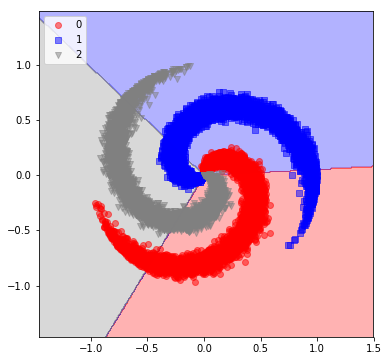

In [20]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Train the model
model.fit(x=X, y=y_onehot, batch_size=32, epochs=10, verbose=1)

# Plot decision boundaries
plot_decision_boundaries(X, y, classifier=model, resolution=0.01)